<a href="https://colab.research.google.com/github/PESALARAVIKUMAR/Helper2/blob/master/UpdatedTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import nltk, string, re, os, time, pandas as pd, numpy as np, emoji, io
from nltk.corpus import stopwords
from nltk.corpus import wordnet
#nltk.download('stopwords')
from nltk.tokenize import (sent_tokenize, word_tokenize, RegexpTokenizer)
#nltk.download('punkt')
from nltk.stem import (PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer)
#nltk.download('wordnet')
from collections import Counter
from bs4 import BeautifulSoup
from emoji.unicode_codes import UNICODE_EMOJI
from spellchecker import SpellChecker
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)

In [0]:
CHAT_WORDS = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

CONTRACTION_PATTERNS = [(r'aren\'t', 'are not'), (r'can\'t', 'cannot'), (r'couldn\'t', 'could not'),
                        (r'could\'ve', 'could have'), (r'didn\'t', 'did not'), (r'doesn\'t', 'does not'),
                        (r'don\'t', 'do not'), (r'e\'er', 'ever'), (r'hadn\'t', 'had not'),
                        (r'hasn\'t', 'has not'), (r'haven\'t', 'have not'), (r'i\'m', 'i am'),
                        (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'),
                        (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'),
                        (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'),
                        (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'),
                        (r'ain\'t', 'is not') ]


In [0]:
class text_preprocessing():
  # __init__(self, data) used to initialize passed data
  def __init__(self, data):
    self.data = data

  # clean_data(self, data) used to call every preprocessing step by passing data
  def clean_data(self):
    self.data['Review'] = self.data['Review'].astype(str)
    # Duplication controll
    self.data = self.data.drop_duplicates(keep='first')
    # Converting Chat words
    self.chat_words_list, self.chat_words_map_dict = self.get_chat_words_list_dict(CHAT_WORDS)
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.convert_chat_words(text, self.chat_words_list, self.chat_words_map_dict))
    # Check Spellings
    # Combined function for (Converting Chat words & Checking Spellings)
    self.data['Review'] = self.data['Review'].apply(lambda text: self.correct_spellings(text))
    # Lower casing & replace Emails with emailaddress
    self.data['Review'] = self.data['Review'].str.lower()
    #self.data['Review'] = self.data['Review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')
    # Removing URL's
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_urls(text))
    # Removing HTML tags
    # Combined function for (Removing URL's & HTML tags)
    self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_html_tags_with_re(text))
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_html_tags_with_BeautifulSoup(text))
    # Removing Contractions (what's --> what is, won't --> will not)
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_contractions(text))
    # Removing Punctuations
    # Combined function for (Removing Contraction's & Punctuations)
    self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_punctuations(text))
    # Replacing Negotiations with Antonmys (not able --> unable)
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.replace_negations(text))
    # Handle Capitalized Words (use when text not converted to LowerCase)
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.handle_capitalized_words(text))
    # Removing Stopwords
    self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_stopwords(text))
    # Removing Frequent Words
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_freq_words(text))
    # Removing Rare Words
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_rare_words(text))
    # Stemming
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.stem_words(text))
    # Lemmatization
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.lemmatize_words(text))
    # Removing Emojis & Emoticons
    #self.data['Review'] = self.data['Review'].apply(lambda text: self.remove_emojis_emoticons(text) if(self.check_emojis_emoticons_present(text)) else text)
    # Converting Emojis & Emoticons
    self.data['Review'] = self.data['Review'].apply(lambda text: self.convert_emoticons(text) if(self.check_emojis_emoticons_present(text)) else text)            
    return self.data

  # get_chat_words_list_dict(self, CHAT_WORDS) used to get all chat words (declared above) into list & dictionary
  def get_chat_words_list_dict(self, CHAT_WORDS):
    chat_words_map_dict = {}
    chat_words_list = []
    for line in CHAT_WORDS.split("\n"):
        if line != "":
            cw = line.split("=")[0]
            cw_expanded = line.split("=")[1]
            chat_words_list.append(cw)
            chat_words_map_dict[cw] = cw_expanded
    chat_words_list = set(chat_words_list)
    return chat_words_list,chat_words_map_dict

  #convert_chat_words(self, text, chat_words_list, chat_words_map_dict) used to free the passed text from chat words
  def convert_chat_words(self, text, chat_words_list, chat_words_map_dict):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

  # correct_spellings(self, text) used to check spellings and correcting them
  def correct_spellings(self, text):
    spell = SpellChecker()
    corrected_text = []
    text = self.convert_chat_words(text, self.chat_words_list, self.chat_words_map_dict)
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

  #remove_urls(self, text) used to remove URL's in the text
  def remove_urls(self, text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

  #remove_html_tags_with_re(self, text) used to remove HTML tags using Regex
  def remove_html_tags_with_re(self, text):
    html_pattern = re.compile('<.*?>')
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', html_pattern.sub(r'', text))

  #remove_html_tags_with_BeautifulSoup(self, text) used to remove HTML tags using BeautifulSoup
  def remove_html_tags_with_BeautifulSoup(self, text):
    return BeautifulSoup(text, "lxml").text

  #replace_repetition_punctuations(self, text) used to remove multiple punctuations at a time with some name
  def replace_repetition_punctuations(self, text):
    #Replaces repetitions of exlamation marks
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)      
    #Replaces repetitions of question marks
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)      
    #Replaces repetitions of stop marks
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

  #remove_punctuations(self, text) used to remove punctucations
  def remove_punctuations(self, text):
    PUNCT_TO_REMOVE = string.punctuation
    text = self.remove_contractions(text)
    return text.translate(str.maketrans('','',PUNCT_TO_REMOVE))

  #remove_contractions(self, text) used to remove contraction
  def remove_contractions(self, text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in CONTRACTION_PATTERNS]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

  #replace_negations(self, text) used to replace negations, helping in converting to antonyms from negations
  def replace_negations(self, text):
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = self.replace_to_antonym(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words

  #replace_to_antonym(self, word, pos = None) used to replace negations to antonyms
  def replace_to_antonym(self, word, pos = None):
    antonyms = set()
    for syn in wordnet.synsets(word, pos = pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None
    
  #handle_capitalized_words(self, text) used to recognize the Capital Words like Abbreviations
  def handle_capitalized_words(self, text):
    words = word_tokenize(text)
    final_text = []
    for word in words:
        if(len(re.findall("[A-Z]{3,}", word))):
            word = word.replace('\\', '' )
            transformed_word = re.sub("[A-Z]{3,}", "ALL_CAPS_"+word, word)
            final_text.append(transformed_word)
        else:
            final_text.append(transformed_word)
    return " ".join(final_text)

  #remove_stopwords(self, text) used to remove stopwords in specific language
  def remove_stopwords(self, text):
    STOPWORDS = set(stopwords.words("english"))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

  #get_most_freq_words(self, data, n_freq_words) used to get most n_freq_words from text vector spaces
  def get_most_freq_words(self, data, n_freq_words):
    counter = Counter()
    for text in data['Review'].values:
        for word in text.split():
            counter[word] += 1
    return set([w for (w,wc) in counter.most_common(n_freq_words)])
    
  #remove_freq_words(self, text) used to remove most frequent words in text vector spaces
  def remove_freq_words(self, text):
    n_freq_words = 10
    FREQ_WORDS = self.get_most_freq_words(data,n_freq_words)
    return " " .join([word for word in str(text).split() if word not in FREQ_WORDS])

  #get_most_rare_words(self, data, n_rare_words) used to get most n_rare_words from text vector spaces
  def get_most_rare_words(self, data, n_rare_words):
    counter = Counter()
    for text in data['Review'].values:
        for word in text.split():
            counter[word] += 1
    return set([w for (w,wc) in counter.most_common()[:-n_rare_words-1:-1]])
    
  #remove_rare_words(self, text) used to remove most rare words in text vector spaces
  def remove_rare_words(self, text):
    n_rare_words = 10
    RARE_WORDS = self.get_most_rare_words(data,n_rare_words)
    return " " .join([word for word in str(text).split() if word not in RARE_WORDS])

  #stem_words(self, text) used to stem the words in text to root form
  def stem_words(self, text):
    stemmer = PorterStemmer()
    return " ".join(stemmer.stem(word) for word in str(text).split())

  #lemmatize_words(self, text) used to lemmatize words
  def lemmatize_words(self, text):
    lemmatizer = WordNetLemmatizer()
    return " ".join(lemmatizer.lemmatize(word) for word in str(text).split())

  #check_emojis_emoticons_present(self, text) used to check if any emoji or emoticons present in text or not
  def check_emojis_emoticons_present(self, text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    if(emoji_pattern.search(text)):
        return True
    else:
        return False
  #if(check_emojis_emoticons_present("game is on 🔥")):
  #  print(convert_emojis("game is on 🔥"))
  #convert_emojis_emoticons(self, text) used to convert the emojis or emoticons into text form
  def convert_emojis_emoticons(self, text):
    for emot in UNICODE_EMOJI:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()), text)
    return text

  #remove_emojis_emoticons(self, text) used to remove all emojis or emoticons in the text
  def remove_emojis_emoticons(self, text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in UNICODE_EMOJI) + u')')
    return emoticon_pattern.sub(r'', text)

  #remove_numbers(self, text) used to remove single numbers
  def remove_numbers(self, text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

  

In [0]:
uploaded = files.upload()

In [0]:
data = pd.read_csv(io.StringIO(uploaded['spam_ham_data.csv'].decode('cp1252')),)

In [41]:
savedData = data
data.shape

(11145, 2)

In [0]:
preprocessing = text_preprocessing(data)

In [0]:
data = preprocessing.clean_data()

In [0]:
#data.shape
#data.head()
data.to_csv('CleanedTextData.csv')

In [0]:
class word_vectorization():
  def __init__(self, data):
    self.data = data

  def BOW_vectorization(self):
    count_vectorizer = CountVectorizer()
    bow_text = count_vectorizer.fit_transform(self.data['Review'])
    bow_feature_names = count_vectorizer.get_feature_names()
    visualizations().plot_frequency_distribution(bow_text, bow_feature_names)
    X = pd.DataFrame(bow_text.toarray(), columns = bow_feature_names)
    Y = data['Liked']
    visualizations().plot_TSNE_distribution(bow_text, Y)
    return X, Y

  def TFIDF_vectorization(self):
    tfidf_vectorizer = TfidfVectorizer(max_features = 5500)
    tfidf_text = tfidf_vectorizer.fit_transform(data['Review'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    visualizations().plot_frequency_distribution(tfidf_text, tfidf_feature_names)
    X = pd.DataFrame(tfidf_text.toarray(), columns = tfidf_feature_names)
    Y = data['Liked']
    visualizations().plot_TSNE_distribution(tfidf_text, Y)
    return X, Y


In [0]:
word_embeddings = word_vectorization(data)

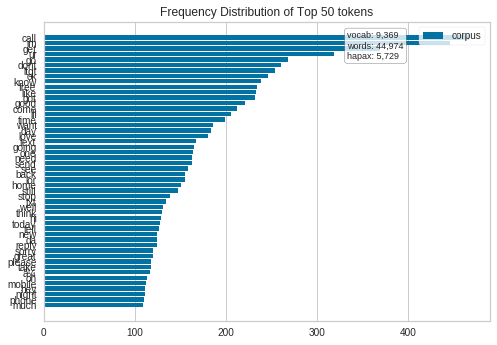

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


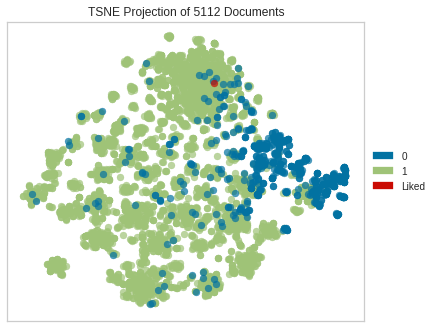

In [182]:
X, Y = word_embeddings.BOW_vectorization()
#X, Y = word_embedding.TFIDF_vectorization()

In [0]:

#X.head()
#Y.head()

In [0]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state = 12)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [0]:
class machine_learning_models():
  def __init__(self, Xtrain, Xtest, Ytrain, Ytest):
    self.Xtrain = Xtrain
    self.Xtest = Xtest
    self.Ytrain = Ytrain
    self.Ytest = Ytest

  def decision_tree_classification(self):
    classifier = DecisionTreeClassifier(
            criterion='gini', splitter='best',  max_depth=None, random_state=None, min_samples_split=2, min_samples_leaf=1, max_features=None
                                              )
    start_time = time.time()
    classifier.fit(self.Xtrain, self.Ytrain)
    predictions = classifier.predict(self.Xtest)
    accuracy = accuracy_score(self.Ytest, predictions)
    elapsed_time = (time.time() - start_time)
    print('Decision Tree Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    error_metrics().confusion_matrix(self.Ytest, predictions)
    error_metrics().classification_report(self.Ytest, predictions)
    #visualizations().plot_roc_auc_curve(self.Ytest, predictions)

  def random_forest_classification(self):
    classifier = RandomForestClassifier(
            criterion='gini', n_estimators=100, max_depth=None, random_state=None, min_samples_split=2, min_samples_leaf=1, max_features=None
                                                  )
    start_time = time.time()
    classifier.fit(self.Xtrain, self.Ytrain)
    predictions = classifier.predict(self.Xtest)
    accuracy = accuracy_score(self.Ytest, predictions)
    elapsed_time = (time.time() - start_time)
    print('Random Forest Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    error_metrics().confusion_matrix(self.Ytest, predictions)
    error_metrics().classification_report(self.Ytest, predictions)
    #visualizations().plot_roc_auc_curve(self.Ytest, predictions)  

  def knn_classification(self):
    classifier = KNeighborsClassifier(n_neighbors=5, algorithm='auto',  n_jobs=None)
    start_time = time.time()
    classifier.fit(self.Xtrain, self.Ytrain)
    predictions = classifier.predict(self.Xtest)
    accuracy = accuracy_score(self.Ytest, predictions)
    elapsed_time = (time.time() - start_time)
    print('KNN Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    error_metrics().confusion_matrix(self.Ytest, predictions)
    error_metrics().classification_report(self.Ytest, predictions)
    #visualizations().plot_roc_auc_curve(self.Ytest, predictions)  

  def multinomialNB_classification(self):
    classifier = MultinomialNB(alpha=1.0, fit_prior=False)
    start_time = time.time()
    classifier.fit(self.Xtrain, self.Ytrain)
    predictions = classifier.predict(self.Xtest)
    accuracy = accuracy_score(self.Ytest, predictions)
    elapsed_time = (time.time() - start_time)
    print('MultinomialNB Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    error_metrics().confusion_matrix(self.Ytest, predictions)
    error_metrics().classification_report(self.Ytest, predictions)
    #visualizations().plot_roc_auc_curve(self.Ytest, predictions)

  def svm_classification(self):
    classifier = SVC(kernel='linear', random_state=None, C=1, gamma=1.0)
    start_time = time.time()
    classifier.fit(self.Xtrain, self.Ytrain)
    predictions = classifier.predict(self.Xtest)
    accuracy = accuracy_score(self.Ytest, predictions)
    elapsed_time = (time.time() - start_time)
    print('SVM Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    error_metrics().confusion_matrix(self.Ytest, predictions)
    error_metrics().classification_report(self.Ytest, predictions)
    #visualizations().plot_roc_auc_curve(self.Ytest, predictions)


In [0]:
ml_models = machine_learning_models(Xtrain, Xtest, Ytrain, Ytest)

Decision Tree Classification :
Accuracy: 0.9629629629629629
Elapsed Time: 17.809000730514526
Confusion Matrix: [[100  29]
 [  9 888]]
Classification report:               precision    recall  f1-score   support

           0       0.92      0.78      0.84       129
           1       0.97      0.99      0.98       897

    accuracy                           0.96      1026
   macro avg       0.94      0.88      0.91      1026
weighted avg       0.96      0.96      0.96      1026



AttributeError: ignored

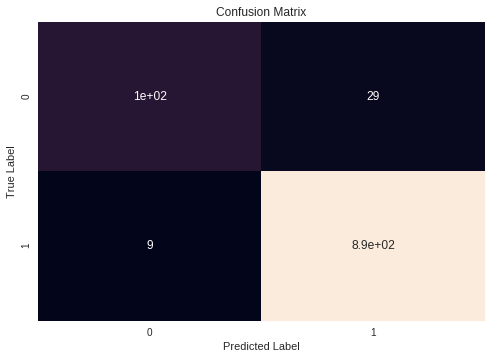

In [196]:
ml_models.decision_tree_classification()
#ml_models.random_forest_classification()
#ml_models.knn_classification()
#ml_models.multinomialNB_classification()
#ml_models.svm_classification()

In [0]:
class visualizations():
  def __init__(self):
    pass

  def plot_roc_auc_curve(self, Ytest, Ypred):
    fpr, tpr, thresholds = roc_curve(Ytest, Ypred, pos_label = 'T')
    roc_auc = auc(fpr, tpr)
    auc_score = roc_auc_score(Ytest, Ypred)
    print('ROC score : {0}'.format(roc_auc))
    print('AUC score : {0}'.format(auc_score))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()  

  # Frequency distribution plots top 50 frequent words
  def plot_frequency_distribution(self, text, feature_names):
    visualizer = FreqDistVisualizer(features=feature_names)
    visualizer.fit(text)
    visualizer.poof()
  #  t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction algorithm for visualizing high-dimensional datasets.
  def plot_TSNE_distribution(self, text, labels):
    tsne = TSNEVisualizer()
    tsne.fit_transform(text, labels)
    tsne.poof()


In [0]:
class error_metrics():
  def __init__(self):
    pass

  def confusion_matrix(self, Ytest, Ypred):
    results = confusion_matrix(Ytest, Ypred)
    print('Confusion Matrix: {0}'.format(results))
    sns.heatmap(results, annot=True, cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')


  def classification_report(self, Ytest, Ypred):
    report = classification_report(Ytest, Ypred)
    print('Classification report: {0}'.format(report))


In [0]:
from yellowbrick.text import (FreqDistVisualizer, TSNEVisualizer)